# Kalman Filter and your Matrix Class

Once you have a working matrix class, you can use the class to run a Kalman filter! 

You will need to put your matrix class into the workspace:
* Click above on the "JUPYTER" logo. 
* Then open the matrix.py file, and copy in your code there. 
* Make sure to save the matrix.py file. 
* Then click again on the "JUPYTER" logo and open this file again.

You can also download this file kalman_filter_demo.ipynb and run the demo locally on your own computer.

Once you have our matrix class loaded, you are ready to go through the demo. Read through this file and run each cell one by one. You do not need to write any code in this Ipython notebook.

The demonstration has two different sections. The first section creates simulated data. The second section runs a Kalman filter on the data and visualizes the results.

### Kalman Filters - Why are they useful?

Kalman filters are really good at taking noisy sensor data and smoothing out the data to make more accurate predictions. For autonomous vehicles, Kalman filters can be used in object tracking. 


### Kalman Filters and Sensors
Object tracking is often done with radar and lidar sensors placed around the vehicle. A radar sensor can directly measure the distance and velocity of objects moving around the vehicle. A lidar sensor only measures distance.

Put aside a Kalman filter for a minute and think about how you could use lidar data to track an object. Let's say there is a bicyclist riding around in front of you. You send out a lidar signal and receive the signal back. The lidar sensor tells you that the bicycle is 10 meters directly ahead of you but gives you no velocity information.

By the time your lidar device sends out another signal, maybe 0.05 seconds will have passed. But during those 0.05 seconds, your vehicle still needs to keep track of the bicycle. So your vehicle will predict where it thinks the bycicle will be. But your vehicle has no bicycle velocity information.

After 0.05 seconds, the lidar device sends out and receives another signal. This time, the bicycle is 9.95 meters ahead of you. Now you know that the bicycle is traveling -1 meter per second towards you. For the next 0.05 seconds, your vehicle will assume the bicycle is traveling -1 m/s towards you. Then another lidar signal goes out and comes back, and you can update the position and velocity again.

### Sensor Noise
Unfortunately, lidar and radar signals are noisy. In other words, they are somewhat inacurrate. A Kalman filter helps to smooth out the noise so that you get a better fix on the bicycle's true position and velocity. 

A Kalman filter does this by weighing the uncertainty in your belief about the location versus the uncertainty in the lidar or radar measurement. If your belief is very uncertain, the Kalman filter gives more weight to the sensor. If the sensor measurement has more uncertainty, your belief about the location gets more weight than the sensor mearuement. 



# Part 1 - Generate Data

The next few cells in the Ipython notebook generate simulation data. Imagine you are in a vehicle and tracking another car in front of you. All of the data you track will be relative to your position.  

In this simulation, you are on a one-dimensional road where the car you are tracking can only move forwards or backwards. For this simulated data, the tracked vehicle starts 5 meters ahead of you traveling at 100 km/h. The vehicle is accelerating at -10 m/s^2. In other words, the vehicle is slowing down. 

Once the vehicle stops at 0 km/h, the car stays idle for 5 seconds. Then the vehicle continues accelerating towards you until the vehicle is traveling at -10 km/h. The vehicle travels at -10 km/h for 5 seconds. Don't worry too much about the trajectory of the other vehicle; this will be displayed for you in a visualization


You have a single lidar sensor on your vehicle that is tracking the other car. The lidar sensor takes a measurment once every 50 milliseconds.

Run the code cell below to start the simulator and collect data about the tracked car. Notice the line 
`import matrix as m`, which imports your matrix code from the final project. You will not see any output yet when running this cell.

In [2]:
%matplotlib inline

import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib
import datagenerator
import matrix as m

matplotlib.rcParams.update({'font.size': 16})

# data_groundtruth() has the following inputs:
# Generates Data
# Input variables are:
# initial position meters
# initial velocity km/h
# final velocity (should be a negative number) km/h
# acceleration (should be a negative number) m/s^2
# how long the vehicle should idle 
# how long the vehicle should drive in reverse at constant velocity
# time between lidar measurements in milliseconds

time_groundtruth, distance_groundtruth, velocity_groundtruth, acceleration_groundtruth = datagenerator.generate_data(5, 100, -10, -10,
                                                                                              5000, 5000, 50)
data_groundtruth = pd.DataFrame(
    {'time': time_groundtruth,
     'distance': distance_groundtruth,
     'velocity': velocity_groundtruth,
     'acceleration': acceleration_groundtruth
    })

### Visualizing the Tracked Object Distance

The next cell visualizes the simulating data. The first visualization shows the object distance over time. You can see that the car is moving forward although decelerating. Then the car stops for 5 seconds and then drives backwards for 5 seconds.

[Text(0,0.5,'distance (meters)'), Text(0.5,0,'time (milliseconds)')]

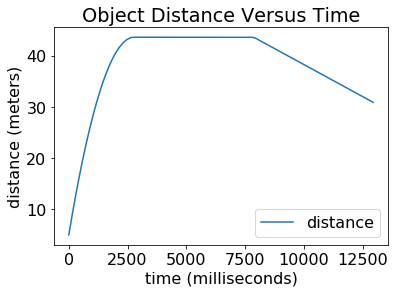

In [3]:
ax1 = data_groundtruth.plot(kind='line', x='time', y='distance', title='Object Distance Versus Time')
ax1.set(xlabel='time (milliseconds)', ylabel='distance (meters)')

### Visualizing Velocity Over Time

The next cell outputs a visualization of the velocity over time. The tracked car starts at 100 km/h and decelerates to 0 km/h. Then the car idles and eventually starts to decelerate again until reaching -10 km/h. 

[Text(0,0.5,'velocity (km/h)'), Text(0.5,0,'time (milliseconds)')]

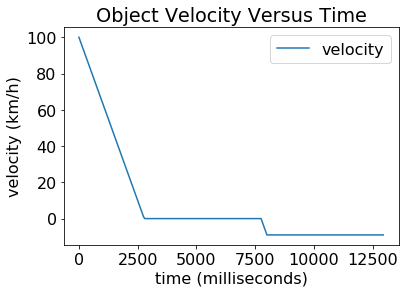

In [4]:
ax2 = data_groundtruth.plot(kind='line', x='time', y='velocity', title='Object Velocity Versus Time')
ax2.set(xlabel='time (milliseconds)', ylabel='velocity (km/h)')

### Visualizing Acceleration Over Time

This cell visualizes the tracked cars acceleration. The vehicle declerates at 10 m/s^2. Then the vehicle stops for 5 seconds and briefly accelerates again. 

[Text(0,0.5,'acceleration (m/s^2)'), Text(0.5,0,'time (milliseconds)')]

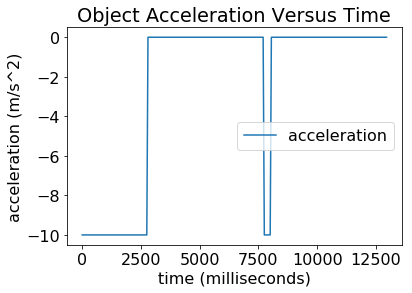

In [5]:
data_groundtruth['acceleration'] = data_groundtruth['acceleration'] * 1000 / math.pow(60 * 60, 2)
ax3 = data_groundtruth.plot(kind='line', x='time', y='acceleration', title='Object Acceleration Versus Time')
ax3.set(xlabel='time (milliseconds)', ylabel='acceleration (m/s^2)')

### Simulate Lidar Data

The following code cell creates simulated lidar data. Lidar data is noisy, so the simulator takes ground truth measurements every 0.05 seconds and then adds random noise.

In [5]:
# make lidar measurements
lidar_standard_deviation = 0.15
lidar_measurements = datagenerator.generate_lidar(distance_groundtruth, lidar_standard_deviation)
lidar_time = time_groundtruth

### Visualize Lidar Meausrements

Run the following cell to visualize the lidar measurements versus the ground truth. The ground truth is shown in red, and you can see that the lidar measurements are a bit noisy.

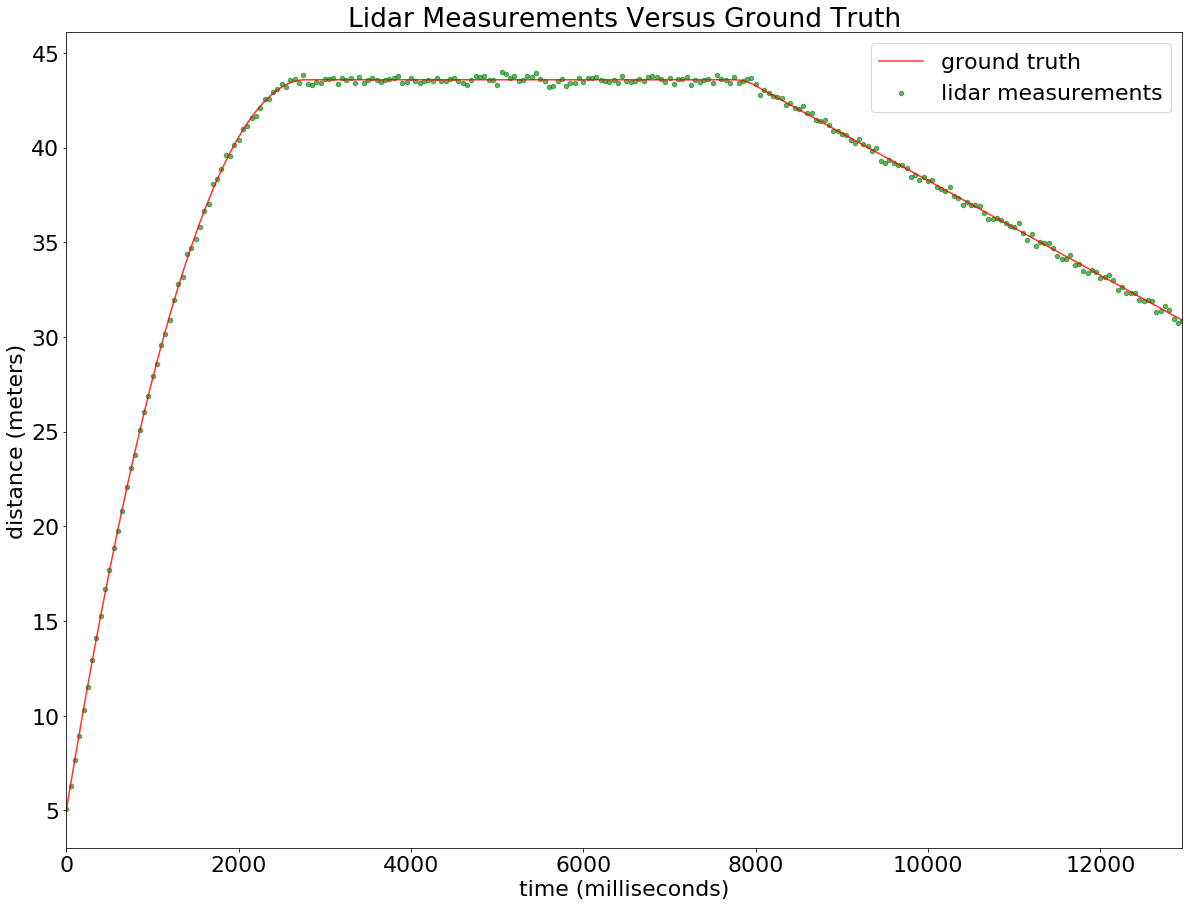

In [6]:
data_lidar = pd.DataFrame(
    {'time': time_groundtruth,
     'distance': distance_groundtruth,
     'lidar': lidar_measurements
    })

matplotlib.rcParams.update({'font.size': 22})

ax4 = data_lidar.plot(kind='line', x='time', y ='distance', label='ground truth', figsize=(20, 15), alpha=0.8,
               title = 'Lidar Measurements Versus Ground Truth', color='red')
ax5 = data_lidar.plot(kind='scatter', x ='time', y ='lidar', label='lidar measurements', ax=ax4, alpha=0.6, color='g')
ax5.set(xlabel='time (milliseconds)', ylabel='distance (meters)')
plt.show()

# Part 2 - Using a Kalman Filter

The next part of the demonstration will use your matrix class to run a Kalman filter. This first cell initializes variables and defines a few functions.

The following cell runs the Kalman filter using the lidar data.



In [7]:
# Kalman Filter Initialization

initial_distance = 0
initial_velocity = 0

x_initial = m.Matrix([[initial_distance], [initial_velocity * 1e-3 / (60 * 60)]])
P_initial = m.Matrix([[5, 0],[0, 5]])

acceleration_variance = 50
lidar_variance = math.pow(lidar_standard_deviation, 2)

H = m.Matrix([[1, 0]])
R = m.Matrix([[lidar_variance]])
I = m.identity(2)

def F_matrix(delta_t):
    return m.Matrix([[1, delta_t], [0, 1]])

def Q_matrix(delta_t, variance):
    t4 = math.pow(delta_t, 4)
    t3 = math.pow(delta_t, 3)
    t2 = math.pow(delta_t, 2)
    
    return variance * m.Matrix([[(1/4)*t4, (1/2)*t3], [(1/2)*t3, t2]])

### Run the Kalman filter

The next code cell runs the Kalman filter. In this demonstration, the prediction step starts with the second lidar measurement. When the first lidar signal arrives, there is no previous lidar measurement with which to calculate velocity. In other words, the Kalman filter predicts where the vehicle is going to be, but it can't make a prediction until time has passed between the first and second lidar reading. 

The Kalman filter has two steps: a prediction step and an update step. In the prediction step, the filter uses a motion model to figure out where the object has traveled in between sensor measurements. The update step uses the sensor measurement to adjust the belief about where the object is.

In [6]:
# Kalman Filter Implementation

x = x_initial
P = P_initial

x_result = []
time_result = []
v_result = []


for i in range(len(lidar_measurements) - 1):
        
    # calculate time that has passed between lidar measurements
    delta_t = (lidar_time[i + 1] - lidar_time[i]) / 1000.0

    # Prediction Step - estimates how far the object traveled during the time interval
    F = F_matrix(delta_t)
    Q = Q_matrix(delta_t, acceleration_variance)
    
    x_prime = F * x
    P_prime = F * P * F.T() + Q
    
    # Measurement Update Step - updates belief based on lidar measurement
    y = m.Matrix([[lidar_measurements[i + 1]]]) - H * x_prime
    S = H * P_prime * H.T() + R
    K = P_prime * H.T() * S.inverse()
    x = x_prime + K * y
    P = (I - K * H) * P_prime

    # Store distance and velocity belief and current time
    x_result.append(x[0][0])
    v_result.append(3600.0/1000 * x[1][0])
    time_result.append(lidar_time[i+1])
    
result = pd.DataFrame(
    {'time': time_result,
     'distance': x_result,
     'velocity': v_result
    })

NameError: name 'x_initial' is not defined

### Visualize the Results

The following code cell outputs a visualization of the Kalman filter. The chart contains ground turth, the lidar measurements, and the Kalman filter belief. Notice that the Kalman filter tends to smooth out the information obtained from the lidar measurement.

It turns out that using multiple sensors like radar and lidar at the same time, will give even better results. Using more than one type of sensor at once is called sensor fusion, which you will learn about in the Self-Driving Car Engineer Nanodegree

NameError: name 'result' is not defined

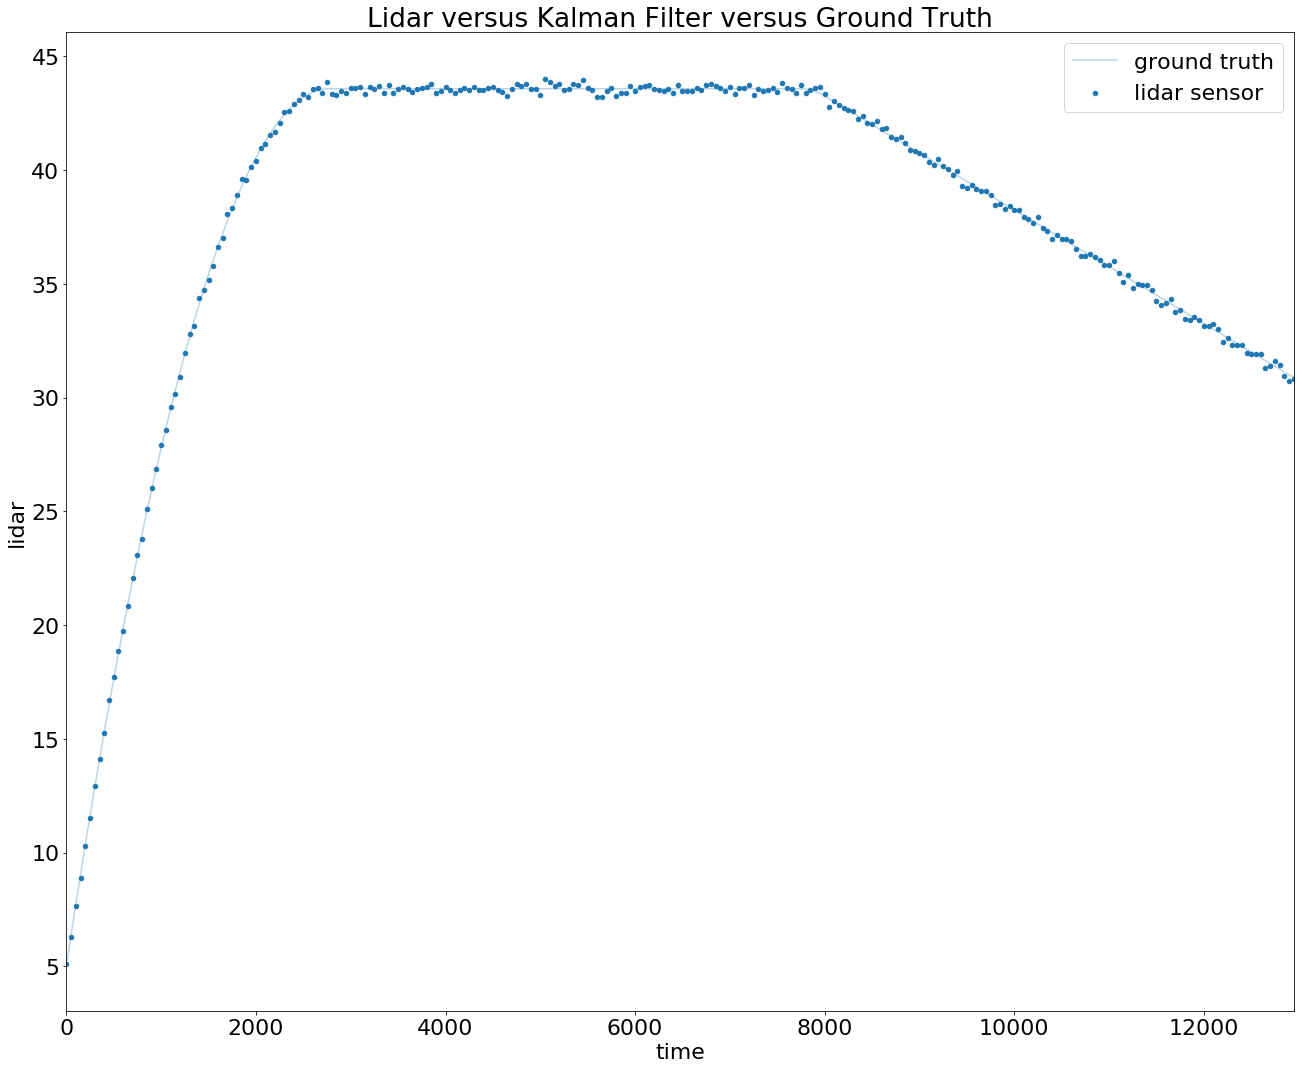

In [9]:
ax6 = data_lidar.plot(kind='line', x='time', y ='distance', label='ground truth', figsize=(22, 18), alpha=.3, title='Lidar versus Kalman Filter versus Ground Truth')
ax7 = data_lidar.plot(kind='scatter', x ='time', y ='lidar', label='lidar sensor', ax=ax6)
ax8 = result.plot(kind='scatter', x = 'time', y = 'distance', label='kalman', ax=ax7, color='r')
ax8.set(xlabel='time (milliseconds)', ylabel='distance (meters)')
plt.show()

### Visualize the Velocity

One of the most interesting benefits of Kalman filters is that they can give you insights into variables that you
cannot directly measured. Although lidar does not directly give velocity information, the Kalman filter can infer velocity from the lidar measurements.

This visualization shows the Kalman filter velocity estimation versus the ground truth. The motion model used in this Kalman filter is relatively simple; it assumes velocity is constant and that acceleration a random noise. You can see that this motion model might be too simplistic because the Kalman filter has trouble predicting velocity as the object decelerates.

In [ ]:
ax1 = data_groundtruth.plot(kind='line', x='time', y ='velocity', label='ground truth', figsize=(22, 18), alpha=.8, title='Kalman Filter versus Ground Truth Velocity')
ax2 = result.plot(kind='scatter', x = 'time', y = 'velocity', label='kalman', ax=ax1, color='r')
ax2.set(xlabel='time (milliseconds)', ylabel='velocity (km/h)')
plt.show()